# Projet Télédétection Avancée UE:901_2  + Qualité et Fouille UE: 906

NOM: **DASSI FENGAING**
Prénom: **Alain Théophile**

Données utilisées: pyrenees_24-25 et échantillons PI_strates_pyrenees_32630

Temps d'exécution du notebook : environ **22 minutes** 


# I. Introduction Générale

La classification d’images de télédétection constitue une étape clé pour transformer des données brutes en cartes thématiques exploitables. Elle permet d’identifier et de discriminer différents types de surfaces (sols nus, végétation, zones artificialisées, cultures, etc.) à partir de leurs signatures spectrales. Les méthodes de classification supervisée, et notamment celles basées sur l’apprentissage automatique, offrent aujourd’hui des performances élevées et une grande capacité de généralisation, à condition d’être correctement paramétrées et validées.

Ce projet s’inscrit dans cette dynamique et vise à mettre en œuvre une chaîne complète de traitement d’images allant du prétraitement des données jusqu’à la production d’une image classifiée finale constituée des classes comme du sol nu, herbe, landes et arbre. Il mobilise des outils de traitement numérique et des bibliothèques scientifiques afin de manipuler les données raster, entraîner un modèle de classification, évaluer l’importance des variables utilisées et générer une sortie cartographique cohérente et exploitable dans un SIG.

Une attention particulière est portée à la gestion des valeurs NoData, à la cohérence radiométrique et à la compatibilité des résultats avec les logiciels de cartographie tels que QGIS. L’objectif final est de produire une carte fiable et interprétable, tout en respectant les bonnes pratiques en télédétection et en traitement des données géospatiales.

Ce travail permet ainsi de consolider des compétences à la fois théoriques et pratiques en télédétection, en analyse spatiale et en programmation appliquée, tout en répondant à des enjeux concrets de production et de qualité de l’information géographique.

Les différents attendus de ce projet sont les suivants:

- Exploiter des séries temporelles d’images Sentinel-2 (pyrenees_24-25) pour analyser l’évolution de la couverture du sol sur un site et une période donnés.

- Analyser les échantillons de photo-interprétation afin d’évaluer la répartition des classes de strates PI_strates_pyrenees_32630) et les déséquilibres en nombre de polygones et de pixels.

- Étudier la phénologie des strates végétales à l’aide du NARI (ARI) et évaluer sa capacité à discriminer la classe des landes au cours de l’année.

- Mettre en place une classification supervisée à l’échelle du pixel à partir des données Sentinel-2 en utilisant un classifieur Random Forest.

- Optimiser et justifier les hyperparamètres du modèle à l’aide d’une recherche sur grille et d’une validation croisée adaptée.

- Évaluer la qualité globale et par classe du modèle de classification à l’aide de métriques appropriées et de matrices de confusion.

- Analyser la contribution des variables explicatives pour identifier les bandes et indices les plus discriminants.

- Produire une carte finale des strates et réaliser une analyse critique des résultats et des confusions observées.

In [87]:
# Importation des bibliothèques utiles
import sys
sys.path.append('/home/onyxia/work/libsigma')
import os
import pandas as pd
import geopandas as gpd
from datetime import datetime
import classification as cla
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import read_and_write as rw
import matplotlib.cm as cm
import plots
from osgeo import gdal, osr, ogr
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold, GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import confusion_matrix, classification_report, \
accuracy_score

# Ma fonction personnel
sys.path.append('/home/onyxia/work/Projet_Teledetection_UE901_21')
import my_function as mf

# Configuration du dossier d'écriture

In [88]:
# Dossier de travail
mon_dossier = '/home/onyxia/work/'

# Dossiers d'écriture
dossier_results = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21', 'resultats')
dossier_figure = os.path.join(dossier_results, 'figure')

# Création si inexistants
os.makedirs(dossier_results, exist_ok=True)
os.makedirs(dossier_figure, exist_ok=True)

## 1. Analyse des échantillons

Cette première partie vise à analyser les échantillons des classes d’occupation du sol afin d’évaluer leur répartition et leur représentativité. Elle permet notamment de déterminer le nombre d’échantillons et de polygones par classe, ainsi que le nombre de pixels associés à chaque classe.

In [89]:
# Chargement des strates d'échantillons
fichier_strates = os.path.join(mon_dossier,'data/projet_eval/PI_strates_pyrenees_32630.shp')
gdf_strates = gpd.read_file(fichier_strates)
#print('type of gdf : ', type(gdf))
gdf_strates

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((686851.853 4758529.727, 686852.251 4..."
1,2,3,lande basse,"POLYGON ((686804.228 4758526.185, 686806.22 47..."
2,3,3,lande basse,"POLYGON ((686820.534 4758490.129, 686821.53 47..."
3,4,3,lande basse + blocs,"POLYGON ((686829.616 4758475.777, 686830.015 4..."
4,5,3,lande basse + blocs,"POLYGON ((686801.094 4758794.649, 686802.091 4..."
...,...,...,...,...
201,62,1,None,"POLYGON ((703448.828 4761113.693, 703455.803 4..."
202,63,1,None,"POLYGON ((703453.571 4761082.183, 703454.169 4..."
203,64,1,None,"POLYGON ((703390.943 4761075.531, 703391.74 47..."
204,65,1,None,"POLYGON ((703517.708 4760288.2, 703517.907 476..."


In [90]:
print("Nombre total de polygones :", len(gdf_strates))
print("\nSystème de projection :")
print(gdf_strates.crs)

Nombre total de polygones : 206

Système de projection :
EPSG:32630


### 1.1. Nombre de polygone par classe.

strate
1    28
2    69
3    78
4    31
Name: count, dtype: int64


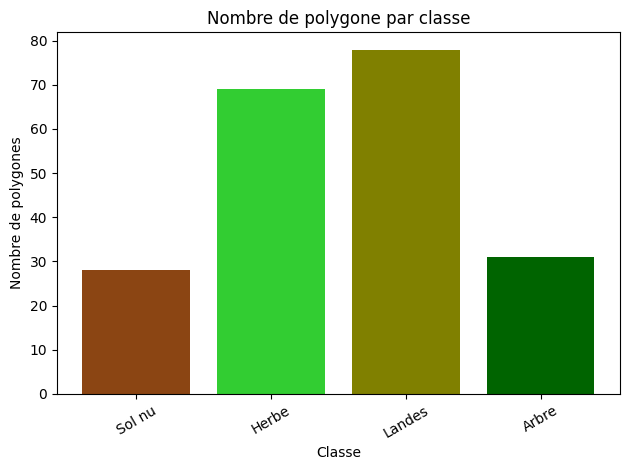

<Figure size 640x480 with 0 Axes>

In [91]:
# Nom du champ de classe 
field_name = "strate"

# Nomenclature des classes et couleurs
class_names = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

class_colors = {
    1: "saddlebrown",
    2: "limegreen",
    3: "olive",
    4: "darkgreen"
}

# Comptage des polygones par classe
counts_poly = gdf_strates[field_name].value_counts().sort_index()

# Remplacer les codes par les noms et couleurs
labels = [class_names[c] for c in counts_poly.index]
colors = [class_colors[c] for c in counts_poly.index]

# affficher nombre de polygone par classe
print(counts_poly)

# diagramme en bar des nombres de polygones par classe
plt.figure()
plt.bar(labels, counts_poly.values, color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygone par classe")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig(os.path.join(mon_dossier,"Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_poly_by_class.png"), dpi=300)

**Commentaire sur le graphique du nombre de polygone par strate**
Les résultats montrent une dominance de la classe Landes (classe 3), qui possède le plus grand nombre de polygones. La classe Herbe (classe 2) arrive en seconde position, suivie par la classe Arbre (classe 4). En revanche, la classe Sol nu (classe 1) est faiblement représentée, ce qui indique une présence limitée de surfaces nues dans les échantillons analysés.

### 1.2. Nombre de pixel par classe.

#### 1.2.1. Rasterization des échantillons par strates

In [92]:
# Rasterization des echantillon polygonale 
out_sample_raster_strate =  os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/sample_raster_strate.tif')

fichier_ref = os.path.join(mon_dossier,"data/projet_eval/pyrenees_24-25_B03.tif")

field_name = "strate"

mf.rasterize_shapefile(fichier_strates, fichier_ref, out_sample_raster_strate, field_name)

# Affichage des charactéristiques des strates rasterisé
mf.print_raster_info(out_sample_raster_strate)

Rasterisation en cours avec ALL_TOUCHED=TRUE...
Raster créé : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/sample_raster_strate.tif
Pixels rasterisés: 950
---- Informations du raster ----
Résolution spatiale X : 10.0 m
Résolution spatiale Y : 10.0 m
Type d’encodage : Byte
Valeur NoData : 0.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


In [93]:
# Chargement du fichier raster des strates d'échantillons
sample_image_raster_strate = rw.load_img_as_array(out_sample_raster_strate).squeeze()

print("Shape raster strates :", sample_image_raster_strate.shape)
print("Classes présentes :", np.unique(sample_image_raster_strate))

Shape raster strates : (1655, 2103)
Classes présentes : [0 1 2 3 4]


**Explications sur la méthode de rasterisation avec Gdal**
Par défaut, GDAL ne rasterise que les pixels dont le centre tombe à l'intérieur du polygone. Par exemple pour des petits polygones (ex: 120 m² avec des pixels de 10×10 m), aucun centre de pixel ne peut tomber dedans, résultant en 0 pixel rasterisé malgré la présence du polygone. Du coup, en utilisant l'option ALL_TOUCHED=TRUE qui rasterise tous les pixels touchés par le polygone, même partiellement, garantie qu'aucun petit polygone ne soit ignoré.

In [94]:
# Comptage des classes d'échantillon

# Exclusion du nodata (0)
valeurs, comptage = np.unique(
    sample_image_raster_strate[sample_image_raster_strate != 0],
    return_counts=True
)

print("\nNombre de pixels par classe :")
for classe, nb_pixels in zip(valeurs, comptage):
    nom = class_names.get(int(classe), "Classe inconnue")
    print(f"{nom} (classe {int(classe)}) : {nb_pixels} pixels")


Nombre de pixels par classe :
Sol nu (classe 1) : 132 pixels
Herbe (classe 2) : 313 pixels
Landes (classe 3) : 364 pixels
Arbre (classe 4) : 141 pixels


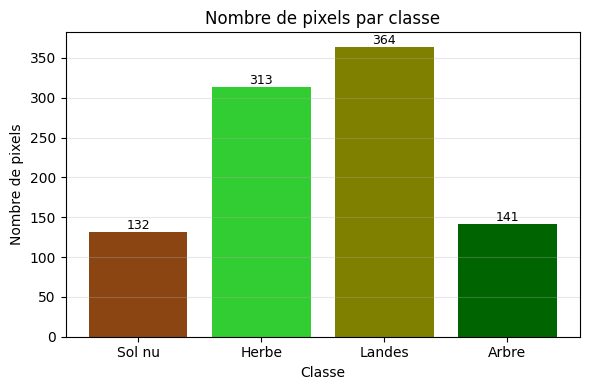

<Figure size 640x480 with 0 Axes>

In [95]:

# Labels et couleurs à partir des dictionnaires
labels = [class_names[int(v)] for v in valeurs]
colors = [class_colors[int(v)] for v in valeurs]

plt.figure(figsize=(6, 4))
plt.bar(labels, comptage, color=colors)

plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.grid(axis="y", alpha=0.3)

# Ajout des valeurs au-dessus des barres
for i, v in enumerate(comptage):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig(os.path.join(mon_dossier,"Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_pix_by_class.png"), dpi=300)

**Interprétation du graphique**
La classification supervisée s’appuie sur un ensemble d’échantillons répartis sur la zone d’étude des Pyrénées. Quatre classes thématiques ont été définies : sol nu, herbe, landes et arbres. La distribution des pixels d’apprentissage montre une représentation majoritairement dominée par les classes landes (364 pixels) et herbe (313 pixels), tandis que les classes arbres (141 pixels) et sol nu (132 pixels) sont moins représentées. Cette répartition traduit une hétérogénéité des échantillons, susceptible d’influencer les performances de la classification, en particulier pour les classes minoritaires.
Ce résultat est cohérent, dans la mesure où le nombre de pixels par classe est directement proportionnel au nombre de polygones par classe identifié lors de l’étape précédente.

# II. Méthodologie
Cette partie décrit la méthode employée pour atteindre les différents objectifs du projet.

**Analyse d'échantillons**
La première étape du projet consiste à analyser les échantillons de référence réalisée ci-dessus. Elle comprend le calcul du nombre de polygones par strate, ainsi que leur représentation graphique, afin d’évaluer la répartition des classes. Toujours concernant les échantillons, le nombre de pixels par strate a également été calculé. Cette opération a été réalisée à l’aide de la fonction rasterize_shapefile(shapefile, ref_raster, out_raster, field_name), qui permet de rasteriser les polygones des strates. La rasterisation prend en compte l’ensemble des pixels intersectant les polygones.

Les descriptions suivantes sont présentées dans les lignes de code suivantes du projet :
**Etude de la phénologie des strates et mise en évidence des landes**
La deuxième partie du projet porte sur l’étude de la phénologie des strates et la mise en évidence des landes. L’objectif est de calculer l’indice Normalized Anthocyanin Reflectance Index (NARI) à partir des bandes B03 et B05. Ce calcul a été effectué à l’aide de la fonction calculate_ari(band3_path, band5_path, output_path), qui applique la formule de l’indice, effectue les traitements nécessaires et enregistre l’image résultante au format GeoTIFF, avec une résolution spatiale de 10 m, un encodage en float32 et une valeur NoData fixée à -9999. L’image produite, intitulée ARI_serie_temp.tif, correspond à une série temporelle composée de 10 bandes, chacune représentant une date de l’indice ARI.

Par la suite, un graphique illustrant l’évolution temporelle de l’ARI moyen, ainsi que son écart-type, a été réalisé pour chaque strate et pour chaque année. Cette analyse a été rendue possible grâce à la fonction compute_class_statistics(image, mask, classes, nodata=-9999), qui permet de calculer les statistiques par classe pour chacune des bandes de la série temporelle.

**Carte de strates à échelle du pixel**
Concernant la production d’une carte de strates à l’échelle du pixel, l’ensemble des bandes spectrales a d’abord été fusionné à l’aide de la fonction
merge_and_save_multiband(raster_paths, output_path, reference_raster_path, nodata=None, dtype=gdal.GDT_Float32). Cette étape a permis d’obtenir une image multispectrale contenant 100 bandes (10 bandes par longueur d’onde), afin d’exploiter l’ensemble des variables explicatives et de maximiser leur contribution à la classification.

Les polygones des strates ont ensuite été rasterisés une seconde fois, cette fois-ci selon leur identifiant de classe, toujours à l’aide de la fonction rasterize_shapefile, afin de gérer correctement les groupes d’appartenance lors de la classification supervisée. L’extraction des échantillons et de leurs labels a été réalisée à l’aide de la fonction vue en cours get_samples_from_roi(multi_band_image, sample_image_raster_strate), adaptée aux échantillons de géométrie polygonale.
exemple:
X, Y, t = cla.get_samples_from_roi(multi_band_image, sample_image_raster_strate) # c'est celui ci qui est utilisé vu que les échantilons sont en polygone
_, groups, _ = cla.get_samples_from_roi(multi_band_image, sample_image_raster_id).

Le classifieur utilisé est un Random Forest. La stratégie de validation repose sur une validation croisée StratifiedGroupKFold, permettant de séparer les échantillons en jeux d’entraînement et de test tout en respectant la structure des groupes. Le modèle a été entraîné à l’aide d’une recherche sur grille comprenant un ensemble d’hyperparamètres prédéfinis. À l’issue de cette phase, le meilleur jeu d’hyperparamètres ainsi que le meilleur modèle ont été sélectionnés et utilisés pour la prédiction sur le jeu de test.

Après la prédiction, une matrice de confusion a été produite afin d’évaluer la qualité du modèle. Les performances ont été mesurées à l’aide de la précision globale et du F1-score. Enfin, la classification a été appliquée à l’ensemble de l’image multispectrale fusionnée, permettant d’obtenir la carte finale des strates à l’échelle du pixel.


# 2. Phénologie des strates, mise en évidence des landes

In [96]:
# insertion des images de bande 3 et 5

pyr_b03 = os.path.join(mon_dossier,'data/projet_eval/pyrenees_24-25_B03.tif')
pyr_b05 = os.path.join(mon_dossier,'data/projet_eval/pyrenees_24-25_B05.tif')

output_path = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/ARI_serie_temp.tif')

# Calcul de l'indice Normalized Anthocyanin Reflectance Index (NARI)

mf.calculate_ari(pyr_b03 , pyr_b05, output_path)

Fichier ARI_serie_temp.tif créé avec succès (série temporelle multi-bandes)


### 2.1. Caractéristiques de l'image NARI ###

In [97]:
# Vérification des caracteristiques de l'image ARI créé
mf.print_raster_info(output_path)

---- Informations du raster ----
Résolution spatiale X : 10.0 m
Résolution spatiale Y : 10.0 m
Type d’encodage : Float32
Valeur NoData : -9999.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


### 2.2. Graphique de l'évolution de l'indice ARI par strates et par dates

Statistiques ARI calculées
Nombre de classes : 4
Nombre de dates : 10


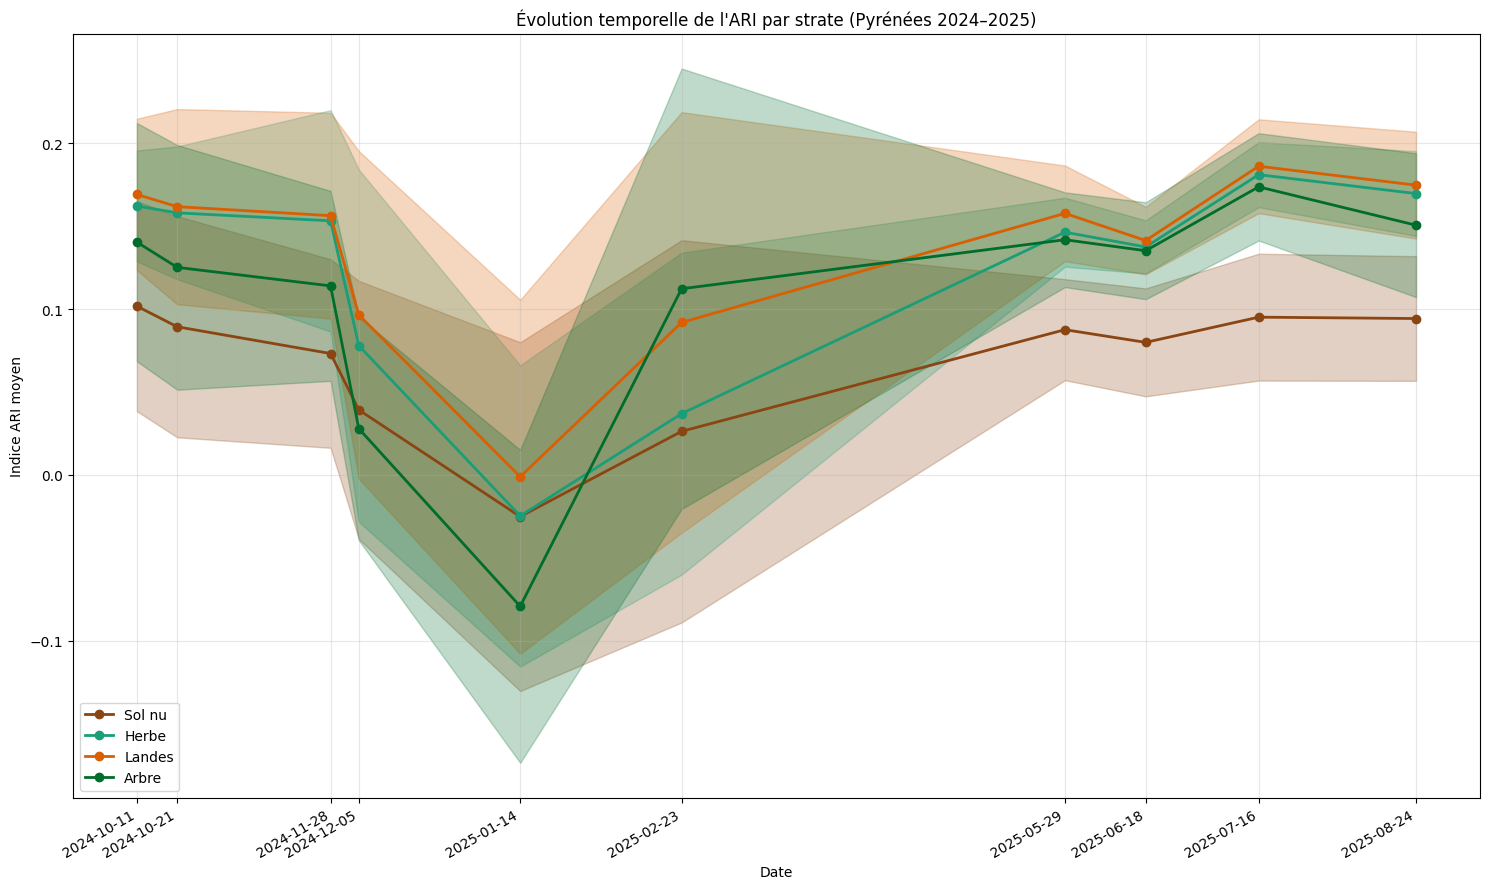

Figure sauvegardée : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/ARI_series.png


In [98]:
# =================================
# Chargement des données nécessaires
# =================================
ari_file = rw.load_img_as_array(output_path)

sample_image_raster_strate = rw.load_img_as_array(out_sample_raster_strate).squeeze()

# =========================
# Dates Sentinel-2 (Pyrénées 2024–2025)
# ORDRE STRICT = ordre des bandes du raster
# =========================
dates_str = [
    "2024-10-11",
    "2024-10-21",
    "2024-11-28",
    "2024-12-05",
    "2025-01-14",
    "2025-02-23",
    "2025-05-29",
    "2025-06-18",
    "2025-07-16",
    "2025-08-24"
]

dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates_str]

# =========================
# Classes
# =========================
classes = [1, 2, 3, 4]

class_names = [
    "Sol nu",
    "Herbe",
    "Landes",
    "Arbre"
]

class_colors = [
    "#8B4513",  # Sol nu
    "#1B9E77",  # Herbe
    "#D95F02",  # Landes
    "#006D2C"   # Arbre
]

# =========================
# Statistiques ARI
# =========================
moyennes, ecarts_types = mf.compute_class_statistics(
    ari_file,
    sample_image_raster_strate,
    classes,
    nodata=-9999
)

nb_classes, nb_dates = moyennes.shape

print("Statistiques ARI calculées")
print(f"Nombre de classes : {nb_classes}")
print(f"Nombre de dates : {nb_dates}")

# correspondance dates ↔ bandes
assert nb_dates == len(dates), (
    "Erreur : le nombre de dates ne correspond pas au nombre de bandes ARI"
)

# =========================
# Figure
# =========================
fig, ax = plt.subplots(figsize=(15, 9))

for i in range(nb_classes):
    mean = moyennes[i, :]
    std = ecarts_types[i, :]

    ax.plot(
        dates,
        mean,
        label=class_names[i],
        color=class_colors[i],
        marker="o",
        linewidth=2
    )

    ax.fill_between(
        dates,
        mean - std,
        mean + std,
        color=class_colors[i],
        alpha=0.25
    )

# =========================
# Axe temporel : dates EXACTES Sentinel-2
# =========================
ax.set_xticks(dates)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# =========================
# Mise en forme
# =========================
ax.set_xlabel("Date")
ax.set_ylabel("Indice ARI moyen")
ax.set_title("Évolution temporelle de l'ARI par strate (Pyrénées 2024–2025)")
ax.legend()
ax.grid(alpha=0.3)

fig.autofmt_xdate()   # rotation propre des dates
plt.tight_layout()

# =========================
# Sauvegarde
# =========================
FIG_DIR = "/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure"
os.makedirs(FIG_DIR, exist_ok=True)

output_fig = os.path.join(FIG_DIR, "ARI_series.png")
plt.savefig(output_fig, dpi=150)
plt.show()

print(f"Figure sauvegardée : {output_fig}")

**Interprétation de l’évolution temporelle du NARI (Pyrénées 2024–2025)**

Le graphique présente l’évolution temporelle de l’indice NARI moyen pour les quatre strates étudiées (sol nu, herbe, landes et arbres) sur la période 2024–2025, ainsi que leur variabilité intra-classe représentée par l’écart-type.

Globalement, on observe une dynamique saisonnière marquée du NARI pour l’ensemble des classes, avec une baisse prononcée des valeurs en hiver (janvier 2025) suivie d’une augmentation progressive au printemps et en été. Cette évolution est cohérente avec la phénologie de la végétation et les variations physiologiques associées aux pigments foliaires.

La classe des landes se distingue nettement des autres strates sur une grande partie de la série temporelle. Elle présente des valeurs de NARI élevées en automne (octobre–novembre 2024), ce qui est en accord avec la forte présence d’anthocyanes chez les Éricacées, particulièrement marquée à cette période de l’année. Cette signature spectrale spécifique constitue un élément discriminant important par rapport aux autres classes.

En hiver, toutes les classes végétalisées (herbe, landes et arbres) montrent une chute significative de l’ARI, avec des valeurs proches de zéro voire négatives, traduisant une diminution de l’activité photosynthétique et une modification de la composition pigmentaire. Cette convergence des signatures spectrales rend la discrimination des classes plus difficile durant cette période.

À partir du printemps (février–mars 2025), les valeurs d’ARI augmentent de nouveau, mais la classe des landes conserve des niveaux globalement supérieurs à ceux de l’herbe et du sol nu, et proches ou légèrement supérieurs à ceux des arbres en été. Cette persistance de valeurs élevées suggère que le NARI reste un indice pertinent pour caractériser les landes, en particulier lors des périodes automnales et estivales.

Les écarts-types montrent par ailleurs une variabilité intra-classe plus importante pour les classes végétalisées, notamment pour les landes et les arbres, ce qui peut s’expliquer par l’hétérogénéité structurelle et physiologique de ces couverts. À l’inverse, le sol nu présente des valeurs d’ARI faibles et relativement stables, confirmant son absence de pigments végétaux.

# 

## 3. Production d’une carte de strates à l’échelle du pixel

### 3.1. Fusion des images mono bandes en une seule image multi bande

In [99]:
# 0. --- Fusion des images mono bande en une image multibandes
directory = "/home/onyxia/work/data/projet_eval/"
extension = ".tif"

files = [
    os.path.join(directory, f)  
    for f in os.listdir(directory)
    if f.startswith("pyrenees_24-25_") and f.endswith(extension)
]


  #fusion des images
output_multibande = os.path.join(
    mon_dossier,
    "Projet_Teledetection_UE901_21/resultats/image_multibande.tif"
)

mf.merge_and_save_multiband(
    raster_paths=files,          
    output_path=output_multibande,
    reference_raster_path=pyr_b03,
    nodata=-9999
)

total_bands = 0
for path in files:
    ds = gdal.Open(path)
    total_bands += ds.RasterCount
    ds = None

print("Nombre total de bandes fusionnées :", total_bands)

Nombre total de bandes fusionnées : 100


### 3.2. Rasterisation des échantillons par identifiant
La rasterisation des échantillons par identifiant permettra de gérer l’appartenance à un polygone ou à un groupe pour la classification supervisée dans les étapes suivantes.

In [100]:
#sortie de la rasterisation par identifiant
out_sample_raster_id=  os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/sample_raster_id.tif')

field_id_name = 'id'
mf.rasterize_shapefile(fichier_strates, fichier_ref, out_sample_raster_id, field_id_name)

# Affichage des charactéristiques des identifiants rasterisé
mf.print_raster_info(out_sample_raster_id)

Rasterisation en cours avec ALL_TOUCHED=TRUE...
Raster créé : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/sample_raster_id.tif
Pixels rasterisés: 950
---- Informations du raster ----
Résolution spatiale X : 10.0 m
Résolution spatiale Y : 10.0 m
Type d’encodage : Byte
Valeur NoData : 0.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


In [101]:
# Chargement du fichier raster des identifiants d'échantillons

sample_image_raster_id = rw.load_img_as_array(out_sample_raster_id).squeeze()

print("Shape raster id :", sample_image_raster_id.shape)
print("Identifiants présents :", np.unique(sample_image_raster_id))

Shape raster id : (1655, 2103)
Identifiants présents : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]


### 3.3. Classification supervisée

In [102]:
# 1 --- Définition des entrées et sorties
# inputs
# Chargement des données utiles
sample_image_raster_strate = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/sample_raster_strate.tif')
multi_band_image = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/image_multibande.tif')
sample_image_raster_id = os.path.join(mon_dossier,'Projet_Teledetection_UE901_21/resultats/sample_raster_id.tif')

# Paramètres des échantillons
nb_iter = 5
nb_folds = 4
is_point = False # if is_point is True

# outputs
suffix = '_CV{}folds_stratified_group_x{}times'.format(nb_folds, nb_iter)
dossier_sortie = os.path.join(mon_dossier, 'results')
sortie_classif = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/carte_strates.tif')
sortie_matrix = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/ma_matrice{}.png'.format(suffix))
sortie_qualite = os.path.join(mon_dossier, 'Projet_Teledetection_UE901_21/resultats/figure/mes_qualites{}.png'.format(suffix))

In [103]:
# 2 --- Paramétrage et extraction des échantillons

# Extraction des échantillons
if not is_point :
    X, Y, t = cla.get_samples_from_roi(multi_band_image, sample_image_raster_strate) # c'est celui ci qui est utilisé vu que les échantilons sont en polygone
    _, groups, _ = cla.get_samples_from_roi(multi_band_image, sample_image_raster_id)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(fichier_strates, image) # Utilisé quand les échantillons son en géométrie point
    image = rw.load_img_as_array(image)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(fichier_strates)
    Y = gdf.loc[:, nom_champs].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

# Y en 1D
Y = np.ravel(Y)

# Affichage des dimensions des données d'entrées
print(X.shape)
print(Y.shape)
print("Classes présentes :", np.unique(Y))

(950, 100)
(950,)
Classes présentes : [1 2 3 4]


In [104]:
# Vérification si X, Y, et groups ont les mêmes dimensions
print(f"Shapes - X: {X.shape}, Y: {Y.shape}, groups: {groups.shape}")
assert len(X) == len(Y) == len(groups), "Tailles incompatibles"

Shapes - X: (950, 100), Y: (950,), groups: (950, 1)


In [105]:
groups = np.squeeze(groups)

# 3 --- Grille d'hyperparamètres
param_grid = {
      "n_estimators": [50, 100, 150, 200, 300],
      "max_depth": [None, 10, 15, 20],
      "max_features": [None, "sqrt", "log2"],
      "min_samples_leaf": [1, 5],
    }
# 4--- Iter on stratified K fold
for i in range(nb_iter) :
  print(f"\n=== Itération {i+1}/{nb_iter} ===")
  # outer cv
  sgkf_outer = StratifiedGroupKFold(n_splits=nb_folds, shuffle=True, random_state=i)
  for train, test in sgkf_outer.split(X, Y, groups=groups):
      X_train, X_test = X[train], X[test]
      Y_train, Y_test = Y[train], Y[test]
      groups_train = groups[train]

      # 5 --- classifier RandomForest
      
      rf = RF(random_state=i)

      # 6 --- Grid Search
         # inner cv
      sgkf_inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

      grid = GridSearchCV(
          estimator=rf,
          param_grid=param_grid,
          cv=sgkf_inner,
          scoring="accuracy",
          n_jobs=-1
        )

      # 7 --- Entraînement
      grid.fit(X_train, Y_train, groups=groups_train)

      # 8 --- Modèle final
      best_model = grid.best_estimator_
  

      # 9 ---Prédiction sur le jeu de test avec le meilleur Modèle 
      Y_predict = best_model.predict(X_test)


      # 10--- Regroupement des qualités après classification
      list_cm.append(confusion_matrix(Y_test, Y_predict))
      list_accuracy.append(accuracy_score(Y_test, Y_predict))
      report = classification_report(Y_test, Y_predict,
                                     labels=np.unique(Y_test),
                                     output_dict=True)

      # 11--- stokage des qualités
      list_report.append(mf.report_from_dict_to_df(report))



=== Itération 1/5 ===



=== Itération 2/5 ===

=== Itération 3/5 ===

=== Itération 4/5 ===

=== Itération 5/5 ===


#### 3.3.1. Meilleur hyperparamètre trouvé et meilleur score Cross Validation

In [106]:
# 12 --- Résultats meilleurs hyperparametre et score cv moyen
print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

print(f"Score CV moyen : {grid.best_score_:.2f}")

Meilleurs hyperparamètres trouvés :
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 300}
Score CV moyen : 0.79


#### 3.3.2. Meilleur Modèle estimé

In [107]:
# 13 --- Modèle final
best_model = grid.best_estimator_
best_model

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### 3.3.3. Explication du classifieur et de sa paramétrisation

**Fusion des bandes et rasterisation des strates**
Les dix bandes des images « pyrenees_24–25 » ont été fusionnées en une seule image multispectrale à l’aide de la fonction merge_and_save_multiband(). Cette étape permet de regrouper l’ensemble de l’information spectrale dans un unique raster multibande, facilitant ainsi les traitements ultérieurs.

Par ailleurs, les strates étant définies sous forme de géométries polygonales, une étape de rasterisation des échantillons par strate (sample_image_raster_strate) et par identifiant (sample_image_raster_id) a été nécessaire afin de permettre l’extraction des valeurs spectrales correspondantes à chaque pixel et de récupérer les identifiants des polygones (les “groupes”) . Cette opération est indispensable pour rendre les données compatibles avec les algorithmes de classification supervisée.

**Extarction des échantillons**
À l’issue de ce prétraitement, l’extraction des échantillons a conduit à la constitution des jeux de données suivants :
X: matrice des variables explicatives, de dimension (950, 100), correspondant à 209 échantillons décrits par 100 bandes spectrales fusionnées;
Y: vecteur des étiquettes de classes de dimension (950,), représentant la classe associée à chaque échantillon ;
groups: vecteur de dimension (950, 1), indiquant l’appartenance de chaque échantillon à un groupe..

**Entrainement du modèle**
Pour l’entraînement et l’évaluation du modèle avec le classifieur **RandomForest**, une validation croisée stratifiée a été mise en œuvre.
Cette approche est particulièrement recommandée lorsque le nombre d’échantillons est limité, comme c’est le cas ici avec seulement **950 échantillons pour l’ensemble des classes**, car elle permet d’utiliser efficacement toutes les données tout en limitant les biais d’échantillonnage.Les échantillons ont été séparés en train et en test à l’aide d’une validation croisée Stratified Group K-Fold. Cette méthode divise les données en K folds, en utilisant successivement un fold pour le test et les K-1 autres pour l’apprentissage.

Le **StratifiedGroupKFold**, a été employée pour **préserver à la fois la distribution des classes dans les jeux d’entraînement et de validation (coté StratifiedKFold) tout en faisant en sorte que les pixels d’un même polygone se trouve dans un seul jeu (coté GroupKFold)**. Plus précisément, c'est une validation croisée imbriquée (nested cross-validation) d'ont le but est de  constituée d'un:
 - **Cv externe (sgkf_outer)** qui coupe le en train/test plusieurs fois et dont le but est **d'évaluer la performance finale du modèle**;
 - **Cv interne (sgkf_inner)** dont le but est de **trouver les meilleurs hyperparamètres sans regarder le test**. 

À l’issue de l’entraînement du modèle avec cinq itérations et une validation croisée à quatre plis externes et trois plis internes (l’inner fold étant moins nombreux que l’outer pour réduire le coût computationnel), la combinaison d’hyperparamètres suivante a été retenue comme optimale :
**{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 300}**.

Cette configuration a obtenu un **score moyen de validation croisée de 0,79**, indiquant un bon compromis entre capacité de modélisation et généralisation sur les données d’entraînement.

La prédiction est ensuite réalisé sur les X_test avec le meilleur model entrainé: Y_predict = best_model.predict(X_test): **Y_predict = best_model.predict(X_test)**.

## 4. Contribution des variables
L’importance des variables désigne la contribution de chaque variable (ou bande spectrale) à la performance d’un modèle de classification. Elle permet d’identifier quelles caractéristiques sont les plus déterminantes pour distinguer les classes. Dans les modèles comme les forêts aléatoires, cette importance est mesurée en fonction de l’amélioration de la pureté des nœuds lors des divisions (gain d’impureté) ou par l’impact sur la performance lorsque la variable est permutée. Cette notion est utile pour comprendre le modèle, réduire le nombre de variables et améliorer la performance en supprimant les variables peu informatives.

Dans cette section, l’importance et la contribution des variables explicatives à la classification sont évaluées sur les dix bandes de l’image multispectrale fusionnée. Cette analyse est effectuée à partir du meilleur modèle entraîné, afin d’identifier les bandes les plus discriminantes utilisées dans la classification.

In [108]:
# Importances du modèle
importances = best_model.feature_importances_

# Bandes Sentinel-2
bands = [
    "B02", "B03", "B04", "B05", "B06",
    "B07", "B08", "B8A", "B11", "B12"
]

# Dates (dans l'ordre)
dates = [
    "2024-10-11",
    "2024-10-21",
    "2024-11-28",
    "2024-12-05",
    "2025-01-14",
    "2025-02-23",
    "2025-05-29",
    "2025-06-18",
    "2025-07-16",
    "2025-08-24"
]

# Génération des noms de variables (100)
feature_names = [
    f"{date}_{band}"
    for date in dates
    for band in bands
]

# Sécurité
assert len(feature_names) == len(importances), \
    "Le nombre de variables ne correspond pas au nombre d'importances"

# DataFrame
df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Date": [date for date in dates for _ in bands],
    "Bande": bands * len(dates),
    "Importance": importances
})

#Affichage des 15 premières lignes
display(df_imp.head(15))


,Variable,Date,Bande,Importance
0,2024-10-11_B02,2024-10-11,B02,0.000360
1,2024-10-11_B03,2024-10-11,B03,0.002770
2,2024-10-11_B04,2024-10-11,B04,0.001370
3,2024-10-11_B05,2024-10-11,B05,0.001622
4,2024-10-11_B06,2024-10-11,B06,0.002256
5,2024-10-11_B07,2024-10-11,B07,0.001828
6,2024-10-11_B08,2024-10-11,B08,0.001629
7,2024-10-11_B8A,2024-10-11,B8A,0.005288
8,2024-10-11_B11,2024-10-11,B11,0.005760
9,2024-10-11_B12,2024-10-11,B12,0.003966


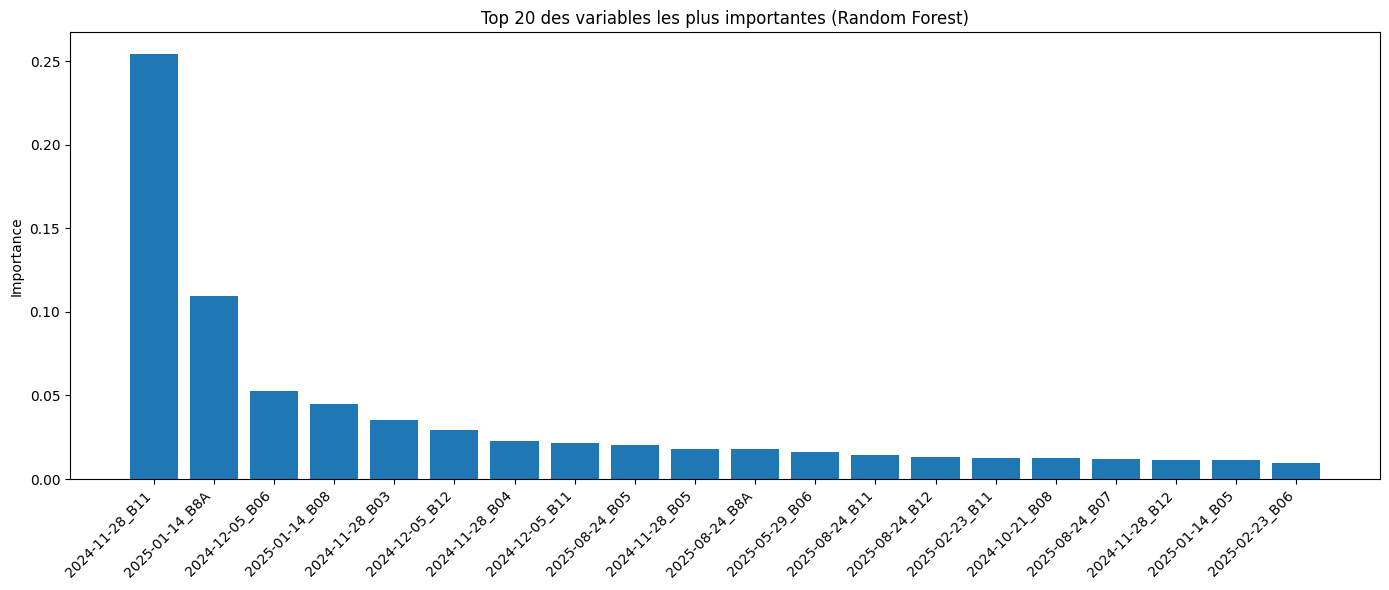

In [109]:
# Conversion en arrays
importances = np.array(importances)
feature_names = np.array(feature_names)

# Tri décroissant
idx_sorted = np.argsort(importances)[::-1]

# Sélection des 20 meilleures variables
top_n = 20
top_idx = idx_sorted[:top_n]

top_importances = importances[top_idx]
top_features = feature_names[top_idx]

# Plot
plt.figure(figsize=(14, 6))
plt.bar(range(top_n), top_importances)
plt.xticks(range(top_n), top_features, rotation=45, ha="right")
plt.title("Top 20 des variables les plus importantes (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

**Interpretation des résultats sur l'importance des variables**

L’analyse de l’importance des variables montre que le modèle Random Forest repose principalement sur les bandes **SWIR (B11, B12) et red-edge / proche infrarouge (B8A, B08, B06)**, en particulier pour des dates automnales et hivernales. Leur forte contribution est cohérente avec l’objectif du projet, qui vise à discriminer différentes strates de couverture du sol, notamment les landes, connues pour leurs spécificités spectrales liées à la présence d’anthocyanes et à leur dynamique saisonnière. Ces variables sont fortement liées à la structure et à l’état physiologique de la végétation, ce qui explique leur fort pouvoir discriminant pour la classification des strates. 
Les autres variables, bien que moins importantes individuellement, contribuent à la robustesse globale du modèle grâce à l’approche multi-temporelle.

## 5. Evaluation des performances du model de classification

### 5.1. calcul de la Matrice de Confusion

In [110]:
# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

### 5.2. Calcul de l'accord globale moyen

In [111]:
# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

### 5.3. Moyenne des rapports de Classification

In [112]:

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)

### 5.4. Affichage des des résultats dans un tableau

In [113]:

a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
mean_df_report

,1,2,3,4
precision,0.863519,0.795175,0.782391,0.803056
recall,0.774237,0.813425,0.806714,0.807223
f1-score,0.801788,0.797357,0.788509,0.796713


In [114]:
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)
std_df_report

,1,2,3,4
precision,0.103312,0.090710,0.096874,0.119219
recall,0.143794,0.091618,0.070207,0.098943
f1-score,0.087444,0.061527,0.055255,0.074447


### 5.5. Affichage du graphique des métriques (Matrice de confusion et Précision globale)

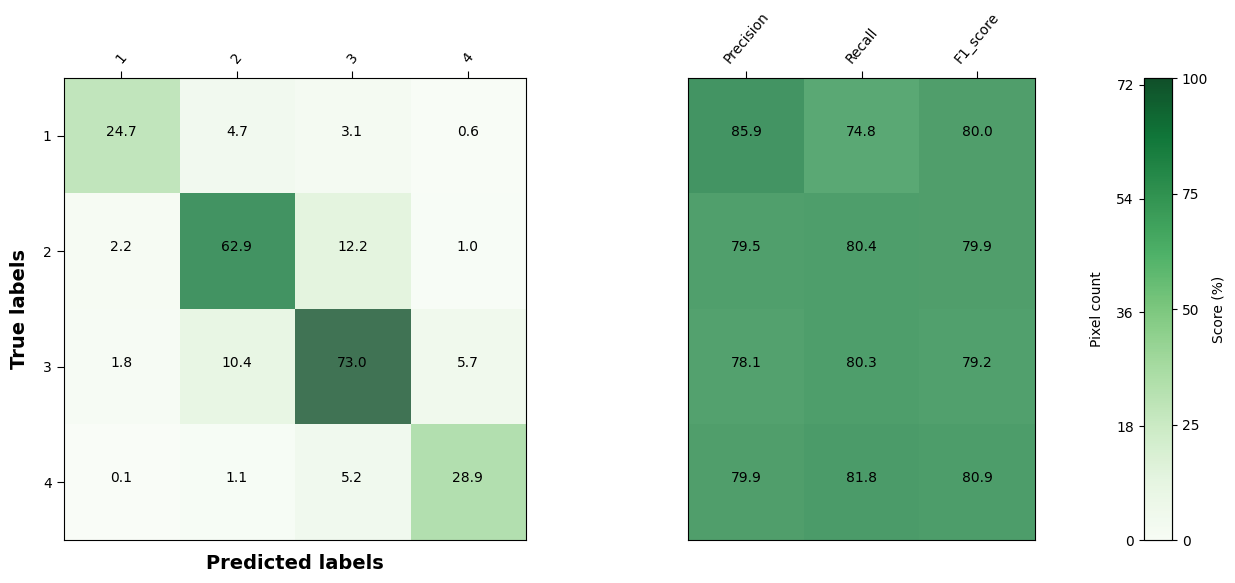

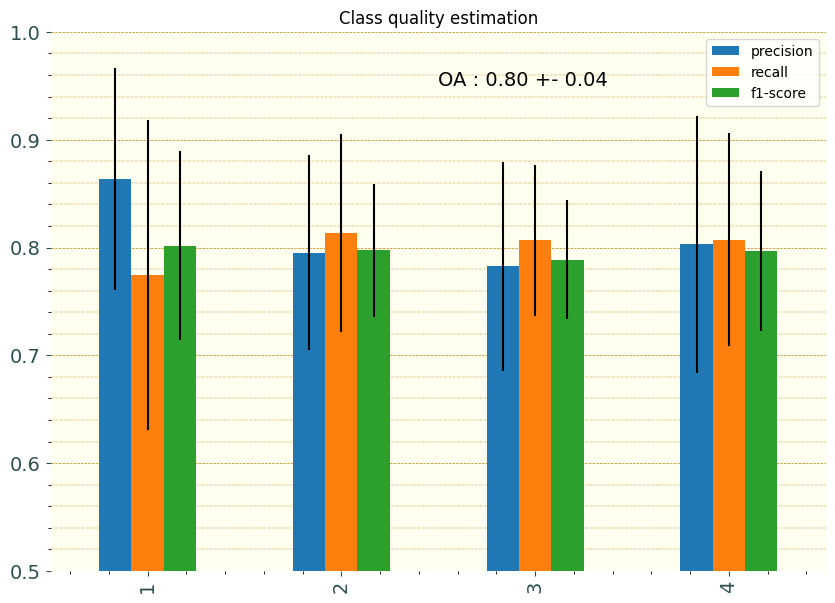

In [115]:
# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)

**Commentaire sur le résultat des métriques obtenus**
La matrice de confusion montre une bonne classification globale des quatre classes, avec des valeurs élevées sur la diagonale, indiquant une majorité de pixels correctement classés. Les classes 2 (Herbe) et 3 (Landes) sont particulièrement bien reconnues, tandis que les principales confusions concernent les classes 2 et 3, ce qui est cohérent avec leurs signatures spectrales proches. Les confusions avec le sol nu (classe 1) et les arbres (classe 4) restent limitées.
Les indicateurs de performance montrent des scores élevés et équilibrés pour l’ensemble des classes, avec des F1-scores proches de 80 %. La classe Sol nu présente une précision élevée mais un rappel plus faible, indiquant une détection plus conservative, tandis que les classes Herbe, Landes et Arbres affichent un bon compromis entre précision et rappel.

**Choix de la métique f1_score**
Le F1-score est utilisé car il combine la précision et le rappel en une métrique unique, offrant une évaluation équilibrée des performances du modèle. Il est particulièrement adapté dans un contexte de classes déséquilibrées et de confusions spectrales, car il pénalise à la fois les faux positifs et les faux négatifs (les erreurs d’omission et de commision), contrairement à la précision globale seule.

## 6. Classification finale sur toute l'image multispectrale avec le meilleur modèle

In [ ]:
# Classification sur toute l'image multispectrale

image_to_be_classified = rw.load_img_as_array(multi_band_image)

rows, cols, bands = image_to_be_classified.shape

X_image_to_be_classified = image_to_be_classified.reshape(rows * cols, bands)

#classification pixels par pixels

y_image_to_be_classified_pred = best_model.predict(X_image_to_be_classified)

In [ ]:
# Reconstruction et enregistrement de l'image l'image classifiée avec

classified_image = y_image_to_be_classified_pred.reshape(rows, cols)

ds = rw.open_image(multi_band_image)

mf.write_classified_image_nodata0(
    sortie_classif,
    classified_image,
    ds_ref=ds,
    gdal_dtype=gdal.GDT_Int8
)

 Image enregistrée avec un type int8 et NoData = 0 : /home/onyxia/work/Projet_Teledetection_UE901_21/resultats/carte_strates.tif


### 6.1. Affichage de l'image classifié

---- Informations du raster ----
Résolution spatiale X : 10.0 m
Résolution spatiale Y : 10.0 m
Type d’encodage : Int8
Valeur NoData : 0.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]


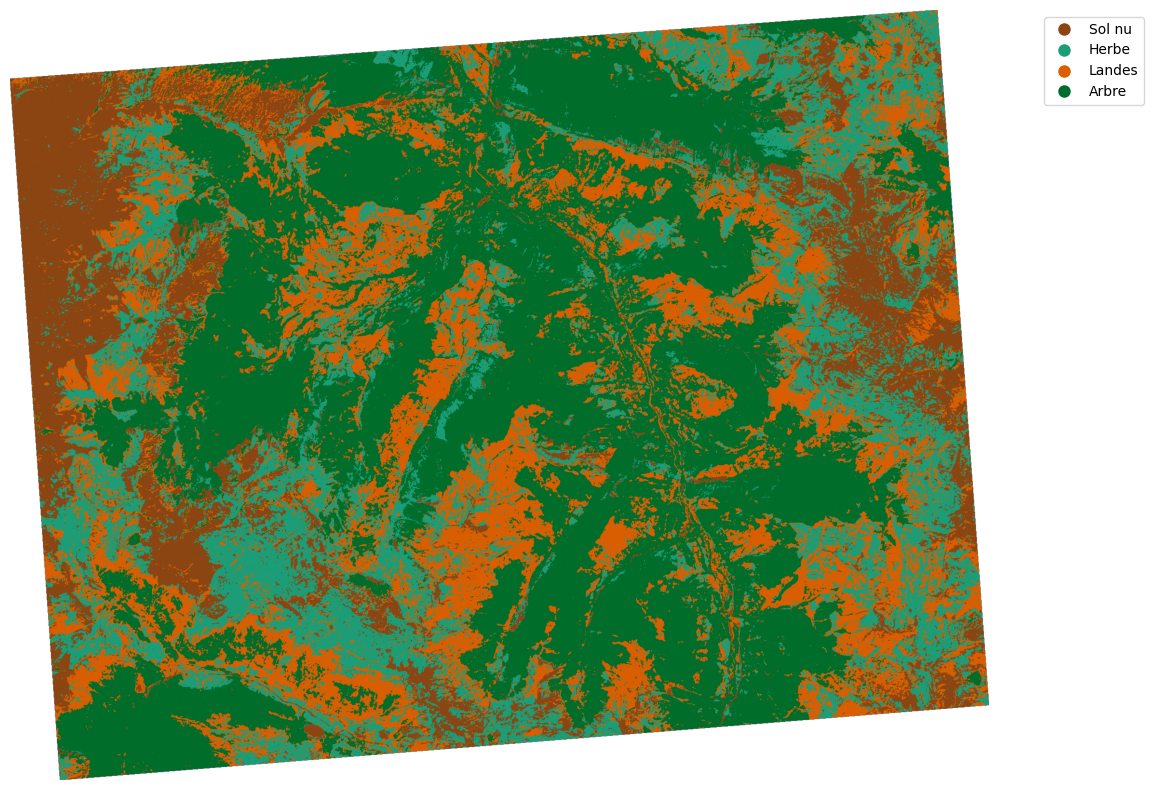

In [ ]:
# ======= Lecture de l'image classifiée =======
ds = gdal.Open(sortie_classif)
band = ds.GetRasterBand(1)
img = band.ReadAsArray()

# ======= Définir les classes et couleurs =======
classes = {
   1: "Sol nu",
   2: "Herbe",
   3: "Landes",
   4: "Arbre"
}

colors = {
    1: (0.5451, 0.2706, 0.0753),  # #8B4513
    2: (0.1059, 0.6196, 0.4667),  # #1B9E77
    3: (0.8509, 0.3725, 0.0078),  # #D95F02
    4: (0.0,    0.4275, 0.1725)   # #006D2C
}

# ======= Lecture de l'image de référence pour le masque =======
file_ref = fichier_ref
ds_ref = gdal.Open(file_ref)
arr_ref = ds_ref.ReadAsArray()

# Masque binaire
mask = (arr_ref[0] > 0) if arr_ref.ndim == 3 else (arr_ref > 0)

# ======= Appliquer le masque sur l'image classifiée =======
img_masked = np.where(mask, img, 0)  # 0 pour zones hors référence

# ======= Créer l'image RGB avec transparence =======
h, w = img.shape
rgb = np.zeros((h, w, 3), dtype=np.float32)
alpha = np.zeros((h, w), dtype=np.float32)  

for cls, col in colors.items():
    mask_cls = (img_masked == cls)
    rgb[mask_cls] = col
    alpha[mask_cls] = 1 

# ======= Affichage avec légende et transparence =======
plt.figure(figsize=(15, 10))
plt.imshow(rgb, alpha=alpha)
plt.axis("off")

# Légende
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=classes[c],
               markerfacecolor=colors[c], markersize=10)
    for c in classes
]

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Afficher les caractéristiques de l'image classifié
mf.print_raster_info(sortie_classif)

#Affichage de l'image avec légende
plt.show()

### 6.2. Proportion des surfaces par classe

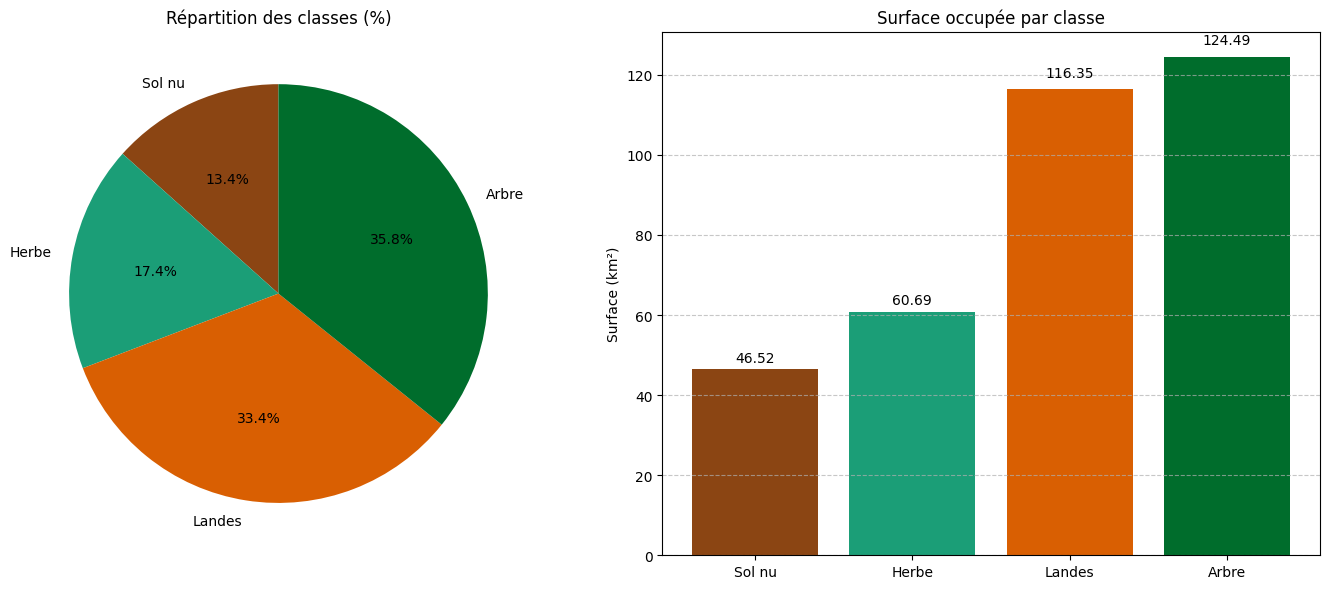

Proportion de surface par classe (%) :
Sol nu : 13.36 %
Herbe : 17.44 %
Landes : 33.43 %
Arbre : 35.77 %

Surface par classe (km²) :
Sol nu : 46.52 km²
Herbe : 60.69 km²
Landes : 116.35 km²
Arbre : 124.49 km²


In [ ]:
# ======= Calcul des surfaces par classe =======
nodata = band.GetNoDataValue()
# Masque NoData si présent
if nodata is not None:
    mask = img != nodata
    total_pixels = np.sum(mask)
else:
    mask = np.ones_like(img, dtype=bool)
    total_pixels = img.size

# Comptage pixels par classe
counts = {cls: np.sum((img == cls) & mask) for cls in classes}

# Calcul de la proportion en %
percent = {cls: (count / total_pixels) * 100 for cls, count in counts.items()}

# ======= Calcul de la surface en km² =======
geotransform = ds.GetGeoTransform()
pixel_width = geotransform[1]   # taille pixel en X (m)
pixel_height = abs(geotransform[5])  # taille pixel en Y (m)
pixel_area_km2 = (pixel_width * pixel_height) / 1e6  # m² → km²

surface_km2 = {cls: count * pixel_area_km2 for cls, count in counts.items()}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -- Camembert
axes[0].pie([percent[c] for c in classes],
            labels=[classes[c] for c in classes],
            colors=[colors[c] for c in classes],
            autopct='%1.1f%%',
            startangle=90)
axes[0].set_title("Répartition des classes (%)")

# -- Diagramme en barres (surface en km²)
bars = axes[1].bar([classes[c] for c in classes],
                   [surface_km2[c] for c in classes],
                   color=[colors[c] for c in classes])
axes[1].set_ylabel("Surface (km²)")
axes[1].set_title("Surface occupée par classe")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# ======= Annoter chaque barre =======
for bar, cls in zip(bars, classes):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.02*height,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# ======= Impression des valeurs =======
print("Proportion de surface par classe (%) :")
for cls in classes:
    print(f"{classes[cls]} : {percent[cls]:.2f} %")

print("\nSurface par classe (km²) :")
for cls in classes:
    print(f"{classes[cls]} : {surface_km2[cls]:.2f} km²")


# III. Discussion des résultats

**Analyse des échantillons (polygones et pixels par strate)**
L’analyse du nombre de polygones et du nombre de pixels par strate met en évidence une répartition inégale des classes. Certaines strates sont représentées par un nombre élevé de polygones et de pixels, tandis que d’autres apparaissent plus marginales. Ceci reflète à la fois : la réalité spatiale du terrain (certaines strates sont naturellement plus étendues), et les choix d’échantillonnage, qui peuvent favoriser les strates les plus visibles ou les plus accessibles.
Cette hétérogénéité des échantillons constitue un élément clé pour interpréter les résultats de classification. Les strates les mieux représentées disposent d’une variabilité spectrale plus riche dans les données d’apprentissage, ce qui favorise leur reconnaissance par le modèle. À l’inverse, les strates moins représentées peuvent être plus sensibles aux confusions, en particulier lorsqu’elles partagent des caractéristiques spectrales proches avec d’autres classes.

**Rasterisation des strates et prise en compte des pixels intersectants les polygones**
La rasterisation des polygones en considérant tout pixel intersectant permet de maximiser le nombre d’échantillons disponibles, notamment le long des frontières entre strates. Cette approche garantit une meilleure couverture spatiale des classes à l’échelle du pixel.
Si cette méthode améliore la densité des échantillons, elle introduit également une incertitude aux limites des polygones, où un même pixel peut contenir un mélange de strates. Cette imprécision géométrique peut expliquer certaines confusions observées ultérieurement dans la classification, en particulier pour les strates aux transitions spatiales progressives.

**Étude phénologique à partir de l’indice NARI**
L’analyse de l’évolution temporelle de l’indice NARI met en évidence des dynamiques phénologiques distinctes selon les strates. Certaines classes présentent des variations saisonnières marquées, tandis que d’autres montrent des profils plus stables dans le temps. Les différences observées sur les valeurs moyennes et les écarts-types traduisent des comportements végétatifs contrastés.
Ces résultats confirment l’intérêt d’un indice sensible aux pigments végétaux, comme le NARI, pour discriminer des strates présentant des signatures spectrales proches en observation mono-date. Toutefois, les écarts-types parfois élevés suggèrent une forte hétérogénéité intra-classe, liée à la variabilité des conditions écologiques locales, à l’état physiologique de la végétation ou à des effets d’illumination et de capteur. Cette variabilité justifie pleinement l’utilisation d’une approche multi-temporelle.

**Fusion multi-bandes et approche multi-temporelle**
La fusion de l’ensemble des bandes spectrales et temporelles aboutit à une image multispectrale riche, intégrant à la fois des informations spectrales fines et temporelles. Cette combinaison permet de mieux capturer la complexité des signatures des strates.
L’utilisation d’un grand nombre de variables explicatives renforce la capacité du modèle à identifier des patterns discriminants. Néanmoins, cette richesse informationnelle peut également introduire des redondances spectrales et un risque de bruit. Le recours à un algorithme robuste comme le Random Forest permet de limiter cet effet grâce à sa capacité à sélectionner implicitement les variables les plus informatives.

**Importance des variables dans la classification**
L’analyse de l’importance des variables montre que certaines bandes ou dates spécifiques contribuent de manière dominante à la discrimination des strates. Cela indique que l’information la plus pertinente n’est pas uniformément répartie dans le temps ni dans le spectre.
Ce résultat souligne le rôle central de certaines périodes phénologiques clés, durant lesquelles les différences entre strates sont maximales. Il met également en évidence que toutes les bandes ne sont pas également utiles, ce qui ouvre la voie à une optimisation future du jeu de variables, en réduisant la dimensionalité tout en conservant les performances.

**QUALITES**

**Matrice de confusion**
La matrice de confusion met en évidence une bonne performance globale du modèle, mais révèle également des confusions non négligeables entre certaines classes. Les classes Herbe (2) et Landes (3) présentent des erreurs croisées relativement importantes, ce qui suggère une proximité spectrale et phénologique entre ces deux strates, notamment à certaines périodes de l’année. On observe également une confusion entre la classe lande et la classe arbre et vice versa. De plus une confusion est marqué entre le sol nu et les  trois autres classes. Toute fois la confusion majeure se trouve entre la classe herbe et lande.
Cette confusion est cohérente avec la nature des formations végétales étudiées et indique une limite intrinsèque de la classification basée uniquement sur l’information spectro-temporelle Sentinel-2.

**Précision, rappel, F1 score**

L’évaluation de la qualité de classification pour chacune des quatre classes, à partir des métriques **précision**, **rappel** et **F1-score**, accompagnées de leurs barres d’erreur issues de la validation croisée. La **précision globale (OA)** moyenne atteint **0,80 ± 0,04**, indiquant une performance globale satisfaisante et relativement stable du modèle Random Forest.

La **classe 1** se distingue par une **précision élevée**, traduisant une bonne capacité du modèle à éviter les faux positifs pour cette classe. En revanche, son **rappel plus faible** révèle que certains pixels appartenant réellement à cette classe ne sont pas détectés, ce qui suggère une confusion partielle avec d’autres strates aux signatures spectrales proches. Le F1-score intermédiaire reflète cet équilibre imparfait entre précision et rappel.

Les **classes 2, 3 et 4** présentent des performances plus homogènes, avec des valeurs de précision, de rappel et de F1-score proches de **0,8**. Cette cohérence indique que le modèle parvient globalement à bien discriminer ces strates, avec un compromis équilibré entre erreurs d’omission et de commission. La classe 3 montre une précision légèrement inférieure mais un rappel plus élevé, ce qui suggère une tendance du modèle à sur-prédire cette classe, au détriment d’autres strates.

Les **barres d’erreur**, parfois relativement larges, mettent en évidence une variabilité non négligeable des performances selon les plis de la validation croisée. Cette variabilité peut être liée à une **hétérogénéité intra-classe**, à un **déséquilibre des échantillons**, ou encore à une proximité spectrale entre certaines strates, en particulier dans un contexte multi-temporel et multi-bandes.

Globalement, le **F1-score**, en tant que métrique synthétique, confirme la robustesse du modèle pour l’ensemble des classes tout en soulignant des marges d’amélioration possibles, notamment pour la classe 1. Ces résultats indiquent que la classification à l’échelle du pixel est globalement fiable, mais que certaines confusions persistent, ce qui ouvre des perspectives d’amélioration via un enrichissement des variables explicatives, une meilleure représentation des classes minoritaires ou l’intégration d’informations spatiales et contextuelles.


# IV. Conclusion

Ce projet a permis de mettre en œuvre une approche complète de cartographie des strates de végétation à partir de séries temporelles Sentinel-2, en combinant analyse phénologique, indices spectraux et classification supervisée. L’exploitation d’images multi-dates a permis de mieux caractériser la variabilité temporelle des strates, en particulier des landes, dont la signature phénologique spécifique a été mise en évidence à l’aide de l’indice NARI.

L’analyse des échantillons a montré une répartition hétérogène des strates, influençant directement les performances de la classification. Malgré ce déséquilibre, le modèle de classification basé sur un Random Forest a produit des résultats globalement satisfaisants, avec une bonne capacité de généralisation et une cohérence spatiale des cartes finales. Les résultats indiquent que certaines strates sont mieux discriminées que d’autres, notamment lorsque leur signature spectrale et temporelle est marquée et bien représentée dans les données d’apprentissage.

L’étude de l’importance des variables a confirmé l’intérêt d’une approche multi-temporelle et multi-spectrale, les bandes du proche infrarouge, du red-edge et du SWIR jouant un rôle clé dans la discrimination des strates. La carte finale produite à l’échelle du pixel constitue ainsi une représentation pertinente de l’occupation des strates sur la zone d’étude.

Des perspectives d’amélioration peuvent être envisagées, notamment par l’intégration d'autres variables explicatives environnementaux, de variables texturales ou topographiques, ou encore par l’utilisation de stratégies de rééquilibrage des classes. L’adoption d’approches tenant compte de la dépendance spatiale ou temporelle pourrait également contribuer à réduire les confusions observées. Un équilibre dans la représentation du nombre de d'échantillons par classe pourrait améliorer la classification et diminuer les confusions entre les classes

Dans le contexte de la mission, les résultats répondent aux objectifs de cartographie des strates de végétation et permettent d’identifier des structures spatiales cohérentes à l’échelle de pixels. Les cartes produites sont ainsi utilisables pour des applications de suivi environnemental, de caractérisation des habitats ou d’analyse territoriale. Elles constituent une base pertinente pour des analyses futures et ouvrent des perspectives vers des méthodes plus avancées visant à améliorer la précision des résultats.